In [48]:
from trainer import preprocess_linear, train_linear, test, train
from dataloader import load_obgn, load_data, preprocess_graph, get_prep_ogbn, get_prep_pubmed

from models.SGCRes import SGCRes
from models.SSGC import SSGC
from models.DGC import DGC
from models.SGC import SGC
from stacked_models import DeepLinear, LinearMLP
from models.GCN import GCN
from dgl.nn.pytorch.conv import SGConv

from dgl.data import CoraGraphDataset, CiteseerGraphDataset, PubmedGraphDataset
import torch.nn as nn
import torch
import torch.nn.functional as F
import dgl
from time import perf_counter
import matplotlib.pyplot as plt


In [49]:
device = 'cpu'
activation = nn.ReLU()
epochs = 50
batch_size = 10000
lr = 0.02
loss_fn = nn.CrossEntropyLoss()
weight_decay = 5e-4
dataset = 'cora'


In [50]:
def train(model, g, features, labels, train_mask, val_mask, lr, weight_decay, epochs, is_linear=False):
    t = perf_counter()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_mask = train_mask.to(device)
    val_mask = val_mask.to(device)
    labels = labels.to(device)
    g = g.to(device)
    features = features.to(device)
    forward_time = []
    backward_time = []
    for epoch in range(epochs):
        model.train()
        logits = None
        t1 = perf_counter()
        if is_linear:
            logits = model(features)
        else:
            logits = model(g, features)
        forward_time.append(perf_counter()-t1)
        loss = loss_fn(logits[train_mask], labels[train_mask])
        optimizer.zero_grad()
        t1 = perf_counter()
        loss.backward()
        optimizer.step()
        backward_time.append(perf_counter()-t1)
        model.eval()
        if is_linear:
            logits = model(features)
        else:
            logits = model(g, features)
        train_acc = torch.sum(logits[train_mask].argmax(1) == labels[train_mask]).item() / train_mask.sum().item()
        val_acc = torch.sum(logits[val_mask].argmax(1) == labels[val_mask]).item() / val_mask.sum().item()
        # test_acc = torch.sum(logits[test_mask].argmax(1) == labels[test_mask]).item() / test_mask.sum().item()
        print(f'Epoch {epoch + 1:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}')

    training_time = perf_counter()-t
    print(f'Training time: {training_time:.4f}s, avg: {training_time/epochs:.4f}')
    print(f'Forward: {sum(forward_time)/len(forward_time)}')
    print(f'Backward: {sum(backward_time)/len(backward_time)}')


def test(model, g, features, labels, mask, is_linear=False):
    model.eval()
    mask = mask.to(device)
    with torch.no_grad():
        logits = None
        if is_linear:
            logits = model(features)[mask]
        else:
            logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        acc = correct.item() * 1.0 / len(labels)
        print(f'Test: {acc:.4f}')
        return acc


In [51]:
dataset = 'cora'
epochs = 50
lr = 0.01
wd = 0.0005
K = 3
T = 2
alpha=0.1

graph, label, split_idx = load_data(dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

graph = preprocess_graph(graph).to(device)
label = label.to(device)
# print(graph.ndata['feat'])
raw_features = graph.ndata['feat'].to(device)

in_feats = raw_features.shape[-1]
n_classes = label.max().item()+1


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [52]:
# params=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
params = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3]
result = []
for alpha in params:
    model = SSGC(in_feats, n_classes, K, alpha, device, is_linear=True)
    train(model, graph, raw_features, label, split_idx["train_mask"], split_idx["val_mask"], lr, float(wd), epochs)
    acc = test(model, graph, raw_features, label, split_idx["test_mask"])
    result.append(acc)


Epoch 01, Loss: 1.9456, Train: 0.3714, Val: 0.1860
Epoch 02, Loss: 1.9427, Train: 0.7286, Val: 0.3840
Epoch 03, Loss: 1.9397, Train: 0.6714, Val: 0.5060
Epoch 04, Loss: 1.9367, Train: 0.6571, Val: 0.5180
Epoch 05, Loss: 1.9338, Train: 0.7857, Val: 0.5860
Epoch 06, Loss: 1.9310, Train: 0.9500, Val: 0.7260
Epoch 07, Loss: 1.9283, Train: 0.9786, Val: 0.7320
Epoch 08, Loss: 1.9256, Train: 0.9500, Val: 0.6380
Epoch 09, Loss: 1.9231, Train: 0.9286, Val: 0.6160
Epoch 10, Loss: 1.9206, Train: 0.9500, Val: 0.6560
Epoch 11, Loss: 1.9182, Train: 0.9714, Val: 0.7300
Epoch 12, Loss: 1.9160, Train: 0.9643, Val: 0.7640
Epoch 13, Loss: 1.9139, Train: 0.9643, Val: 0.7700
Epoch 14, Loss: 1.9118, Train: 0.9643, Val: 0.7640
Epoch 15, Loss: 1.9099, Train: 0.9643, Val: 0.7600
Epoch 16, Loss: 1.9081, Train: 0.9643, Val: 0.7600
Epoch 17, Loss: 1.9063, Train: 0.9643, Val: 0.7700
Epoch 18, Loss: 1.9047, Train: 0.9714, Val: 0.7540
Epoch 19, Loss: 1.9031, Train: 0.9714, Val: 0.7440
Epoch 20, Loss: 1.9016, Train: 

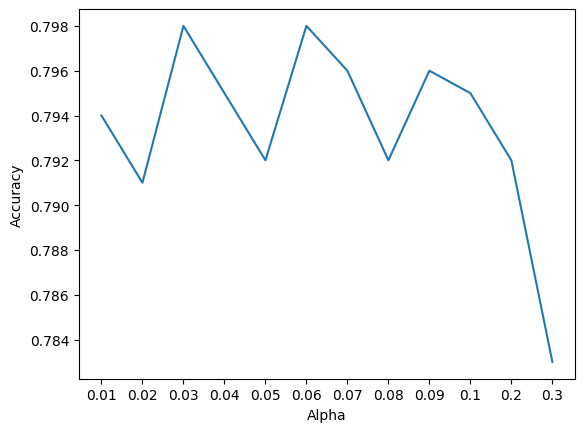

In [53]:
plt.plot(result)
plt.xlabel('Alpha')
plt.xticks(range(len(params)), params)
plt.ylabel('Accuracy')
plt.show()
